# Imports and setting up viz

NB : conda env1 on Mac, lam1env on spirit (Python3.12)

In [86]:
import numpy as np
import netCDF4 as nc
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
import cartopy.crs as ccrs
import cartopy
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from scipy.stats import ttest_ind
%matplotlib inline

In [87]:
plt.rcParams.update(
        {
            'figure.facecolor': 'white',
            'axes.facecolor': 'white',
            'font.size': 12,
            'figure.dpi': 72.0,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.size': 5.0,
            'xtick.minor.size': 2.5,
            'ytick.major.size': 5.0,
            'ytick.minor.size': 2.5,
            'xtick.minor.visible': True,
            'ytick.minor.visible': True,
            'axes.grid': True,
            'axes.titlesize': 'larger',
            'axes.labelsize': 'larger',
            'grid.color': 'dimgray',
            'grid.linestyle': '-',
            'grid.alpha': 0.3,
            'axes.prop_cycle': cycler(
                color=[
                    '#0C5DA5',
                    '#FF9500',
                    '#00B945',
                    '#FF2C00',
                    '#845B97',
                    '#474747',
                    '#9E9E9E',
                ]
            ) * cycler(alpha=[0.8]),
            'scatter.marker': 'x',
            'lines.linewidth': 1.0,
        })

In [88]:
rivers = cartopy.feature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m',edgecolor=(0, 0, 0, 0.3), facecolor='none')

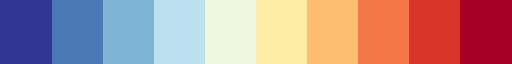

In [89]:
#define centered colorbar
emb = ListedColormap(mpl.colormaps['RdYlBu_r'](np.linspace(0, 1, 10)))
emb

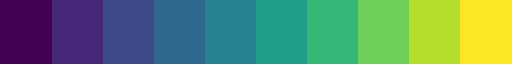

In [90]:
#define progressive colorbar
myvir = ListedColormap(mpl.colormaps['viridis'](np.linspace(0, 1, 10)))
myvir

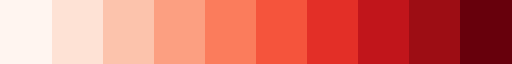

In [91]:
#define progressive colorbar
reds = ListedColormap(mpl.colormaps['Reds'](np.linspace(0, 1, 10)))
reds

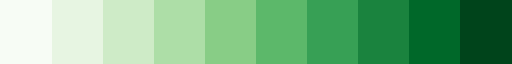

In [92]:
#define progressive colorbar
greens = ListedColormap(mpl.colormaps['Greens'](np.linspace(0, 1, 10)))
greens

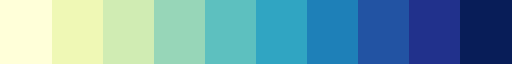

In [93]:
#define progressive colorbar
wet = ListedColormap(mpl.colormaps['YlGnBu'](np.linspace(0, 1, 10)))
wet

# Load files

LAM output analysis.

Simu irr et simu no-irr.

In [94]:
noirr_dir='../../../JZ_simu_outputs/LAM/noirr_2010_2022'
irr_dir='../../../JZ_simu_outputs/LAM/irr_2010_2022'

In [95]:
#open histmth files
filename = '{}/ATM/TS*.nc'.format(noirr_dir)
sim_noirr0 = xr.open_mfdataset(filename)

In [96]:
filename = '{}/ATM/TS*.nc'.format(irr_dir)
sim_irr0 = xr.open_mfdataset(filename)
sim_irr0

<xarray.Dataset>
Dimensions:            (time_counter: 156, lon: 200, lat: 200, bnds: 2)
Coordinates:
  * time_counter       (time_counter) datetime64[ns] 2010-01-16T12:00:00 ... ...
  * lon                (lon) float32 -13.0 -12.89 -12.79 ... 7.789 7.894 8.0
  * lat                (lat) float32 30.0 30.1 30.2 30.3 ... 49.7 49.8 49.9 50.0
Dimensions without coordinates: bnds
Data variables: (12/41)
    time_counter_bnds  (time_counter, bnds) datetime64[ns] dask.array<chunksize=(156, 2), meta=np.ndarray>
    LWdnSFC            (time_counter, lat, lon) float32 dask.array<chunksize=(156, 200, 200), meta=np.ndarray>
    LWupSFC            (time_counter, lat, lon) float32 dask.array<chunksize=(156, 200, 200), meta=np.ndarray>
    SWdnSFC            (time_counter, lat, lon) float32 dask.array<chunksize=(156, 200, 200), meta=np.ndarray>
    SWupSFC            (time_counter, lat, lon) float32 dask.array<chunksize=(156, 200, 200), meta=np.ndarray>
    ale                (time_counter, lat, lon) float32 dask.array<chunksize=(156, 200, 200), meta=np.ndarray>
    ...                 ...
    t200               (time_counter, lat, lon) float32 dask.array<chunksize=(156, 200, 200), meta=np.ndarray>
    t2m                (time_counter, lat, lon) float32 dask.array<chunksize=(156, 200, 200), meta=np.ndarray>
    t500               (time_counter, lat, lon) float32 dask.array<chunksize=(156, 200, 200), meta=np.ndarray>
    t700               (time_counter, lat, lon) float32 dask.array<chunksize=(156, 200, 200), meta=np.ndarray>
    t850               (time_counter, lat, lon) float32 dask.array<chunksize=(156, 200, 200), meta=np.ndarray>
    wape               (time_counter, lat, lon) float32 dask.array<chunksize=(156, 200, 200), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.3.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    name:         histmth
    description:  Created by xios
    title:        Created by xios
    timeStamp:    2024-Apr-08 20:57:13 GMT
    uuid:         29e26a36-b630-44f8-a191-bf9e515af81c
    history:      Fri Jun 28 14:58:59 2024: cdo mergetime sim15_LWdnSFC.nc si...
    NCO:          netCDF Operators version 5.0.7 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 2.3.0 (https://mpimet.mpg.de...

In [97]:
one_file=xr.open_dataset('/data/ptiengou/JZ_simu_outputs/LAM/noirr_2010_2022/ATM/MO/sim12_20150101_20150131_1M_histmth.nc')
one_file

<xarray.Dataset>
Dimensions:               (klevp1: 80, bnds: 2, klev: 79, lat: 200, lon: 200,
                           time_counter: 1, axis_nbounds: 2)
Coordinates:
  * klevp1                (klevp1) float64 1.0 2.0 3.0 4.0 ... 78.0 79.0 80.0
  * bnds                  (bnds) float32 1.0 2.0
  * klev                  (klev) float64 1.0 2.0 3.0 4.0 ... 76.0 77.0 78.0 79.0
  * lat                   (lat) float32 30.0 30.1 30.2 30.3 ... 49.8 49.9 50.0
  * lon                   (lon) float32 -13.0 -12.89 -12.79 ... 7.789 7.894 8.0
    time_centered         (time_counter) datetime64[ns] ...
  * time_counter          (time_counter) datetime64[ns] 2015-01-16T12:00:00
    time_instant          (time_counter) datetime64[ns] ...
Dimensions without coordinates: axis_nbounds
Data variables: (12/78)
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] ...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] ...
    time_instant_bounds   (time_counter, axis_nbounds) datetime64[ns] ...
    Ahyb                  (klevp1) float32 ...
    Ahyb_bounds           (bnds, klevp1) float32 ...
    Bhyb                  (klevp1) float32 ...
    ...                    ...
    q500                  (time_counter, lat, lon) float32 ...
    q200                  (time_counter, lat, lon) float32 ...
    z850                  (time_counter, lat, lon) float32 ...
    z700                  (time_counter, lat, lon) float32 ...
    z500                  (time_counter, lat, lon) float32 ...
    z200                  (time_counter, lat, lon) float32 ...
Attributes:
    name:         histmth
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2024-Apr-11 06:26:42 GMT
    uuid:         53a3dfb8-398d-4d5d-ac15-f869740c6a6c

# File manipulations

In [98]:
sim_noirr = sim_noirr0.rename({'time_counter':'time'})
sim_noirr.attrs['name'] = 'no_irr'
sim_noirr = sim_noirr.sel(lon=slice(-13,6),lat=slice(32,49))

sim_noirr['evap']=sim_noirr['evap'] * 3600 * 24
sim_noirr['evap'].attrs['units']='mm/d'
sim_noirr['sens']=-sim_noirr['sens']
sim_noirr['flat']=-sim_noirr['flat']

In [99]:
sim_irr = sim_irr0.rename({'time_counter':'time'})
sim_irr.attrs['name'] = 'irr'
sim_irr = sim_irr.sel(lon=slice(-13,6),lat=slice(32,49))

sim_irr['evap']=sim_irr['evap'] * 3600 * 24
sim_irr['evap'].attrs['units']='mm/d'
sim_irr['sens']=-sim_irr['sens']
sim_irr['flat']=-sim_irr['flat']


In [100]:
# Select months
months=[6,7,8]
sim_irr = sim_irr.sel(time=sim_irr['time.month'].isin(months))
sim_noirr = sim_noirr.sel(time=sim_noirr['time.month'].isin(months))

# Maps

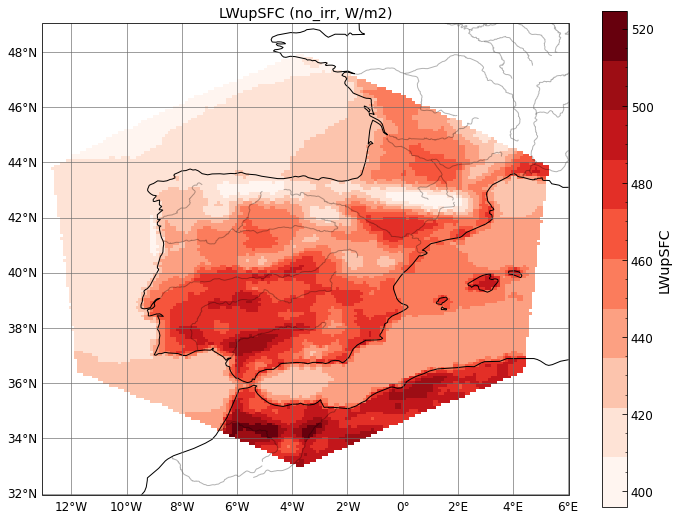

In [101]:
#Display map of var for ds
var=''
ds=sim_noirr
color_map=reds
max_value=None
plotvar = ds[var].mean(dim='time') #*100 #*3600*24
fig = plt.figure(figsize=(10, 7.5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(rivers)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.8)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = plt.MaxNLocator(10)
gl.ylocator = plt.MaxNLocator(9)
#use colormap reds
plotvar.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=color_map, vmax=max_value)
plt.title(var + ' ({}, {})' .format(ds.attrs['name'], ds[var].attrs['units']))
# plt.title('Applied irrigation (mm/day)')# ({})' .format(ds[var].attrs['units']))
plt.tight_layout()

Text(0.5, 1.0, 's_lcl difference (JJA, irr - no_irr, m)')

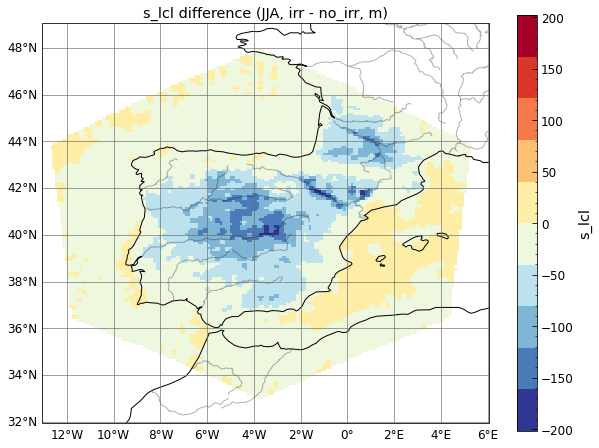

In [123]:
#Diff map
var='s_lcl'
max_value=30
min_value = - max_value
max_value= None
min_value = None
ds1=sim_irr
ds2=sim_noirr
#compute diff between ds1 and ds2
diff = (ds1[var]-ds2[var]).mean(dim='time') 

#display map
fig = plt.figure(figsize=(10, 7.5))
ax = plt.axes(projection=ccrs.PlateCarree())
# gridline setup
ax.coastlines()
ax.add_feature(rivers)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.8)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = plt.MaxNLocator(10)
gl.ylocator = plt.MaxNLocator(9)

# diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=emb, vmax=max_value)
diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=emb, vmin=min_value, vmax=max_value)
# p_values.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=emb, vmax=max_value)
plt.title(var + ' difference (JJA, ' + ds1.name + ' - ' + ds2.name + ', ' + ds1[var].attrs['units'] + ')')
# plt.title('PBL height difference (irr - no_irr, April to September, m)')

Text(0.5, 1.0, 's_lcl difference (JJA, irr - no_irr, m)')

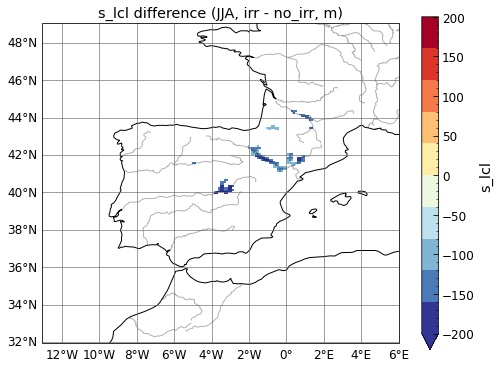

In [125]:
#Diff map with significance
var='s_lcl'
max_value=200
min_value = - max_value
# max_value= None
# min_value = None
ds1=sim_irr
ds2=sim_noirr
#compute diff between ds1 and ds2
diff = (ds1[var]-ds2[var]).mean(dim='time') 
#assess statistical significance
p_values = xr.apply_ufunc(
    lambda x, y: ttest_ind(x, y, axis=0, nan_policy='omit').pvalue, 
    ds1[var], ds2[var],
    input_core_dims=[['time'], ['time']],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)
mask=p_values<0.05

#display map
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
# gridline setup
ax.coastlines()
ax.add_feature(rivers)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.8)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = plt.MaxNLocator(10)
gl.ylocator = plt.MaxNLocator(9)

# diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=emb, vmax=max_value)
diff.where(mask).plot(ax=ax, transform=ccrs.PlateCarree(), cmap=emb, vmin=min_value, vmax=max_value)
# p_values.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=emb, vmax=max_value)
plt.title(var + ' difference (JJA, ' + ds1.name + ' - ' + ds2.name + ', ' + ds1[var].attrs['units'] + ')')
# plt.title('PBL height difference (irr - no_irr, April to September, m)')

Text(0.5, 1.0, 'pvalues for cin, JJA')

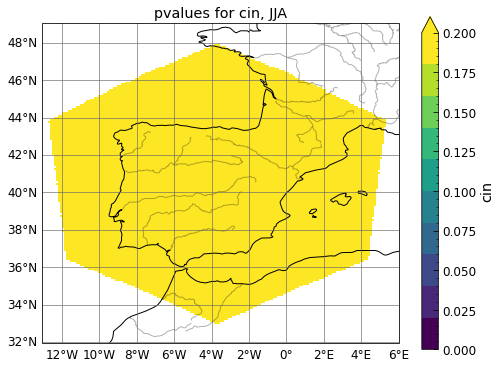

In [81]:
#pvalue plot
var='cin'
max_value=0.2
min_value=0
ds1=sim_irr
ds2=sim_noirr
p_values = xr.apply_ufunc(
    lambda x, y: ttest_ind(x, y, axis=0, nan_policy='omit').pvalue, 
    ds1[var], ds2[var],
    input_core_dims=[['time'], ['time']],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)

#display map
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.PlateCarree())
# gridline setup
ax.coastlines()
ax.add_feature(rivers)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.8)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = plt.MaxNLocator(10)
gl.ylocator = plt.MaxNLocator(9)

p_values.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=myvir, vmin=min_value, vmax=max_value)
plt.title('pvalues for {}, JJA'.format(var))

Text(0.5, 1.0, 'flat (no_irr)')

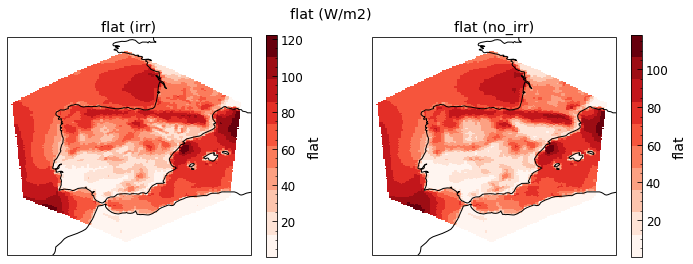

In [82]:
# Display 2 maps of var
var = 'flat'
maxvalue=None
color_map=reds

ds1 = sim_irr
ds2 = sim_noirr
plotvar_1 = ds1[var].mean(dim='time') #*3600*24
plotvar_2 = ds2[var].mean(dim='time') #*3600*24

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle(var + ' ({})'.format(ds1[var].units))

# Plot for std dataset
axs[0].coastlines()
plotvar_1.plot(ax=axs[0], transform=ccrs.PlateCarree(), cmap=color_map, vmax=maxvalue)
axs[0].set_title(f'{var} ({ds1.name})')

# Plot for natORC dataset
axs[1].coastlines()
plotvar_2.plot(ax=axs[1], transform=ccrs.PlateCarree(), cmap=color_map, vmax=maxvalue)
axs[1].set_title(f'{var} ({ds2.name})')

Text(0.5, 1.0, 'sfcWind relative difference (irr - no_irr; %)')

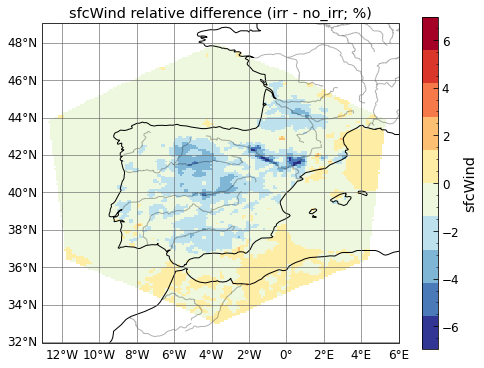

In [83]:
#Relative diff map
var='sfcWind'
maxvalue=None
ds1=sim_irr
ds2=sim_noirr
#compute diff between ds1 and ds2
diff = (ds1[var]-ds2[var]).mean(dim='time')
rel_diff = ((ds1[var]-ds2[var] + 1E-16) / (ds2[var] + 1E-16)).mean(dim='time') * 100
# Transform rel_diff using log10
rel_diff_log = np.log10(rel_diff)
#display map
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(rivers)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.8)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = plt.MaxNLocator(10)
gl.ylocator = plt.MaxNLocator(9)
rel_diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=emb, vmax=maxvalue)
# rel_diff_log.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=emb)
plt.title(var + ' relative difference (' + ds1.name + ' - ' + ds2.name + '; %)')
# plt.title('Gross primary production relative difference (%)')

Text(0.5, 1.0, 't2m (no_irr)')

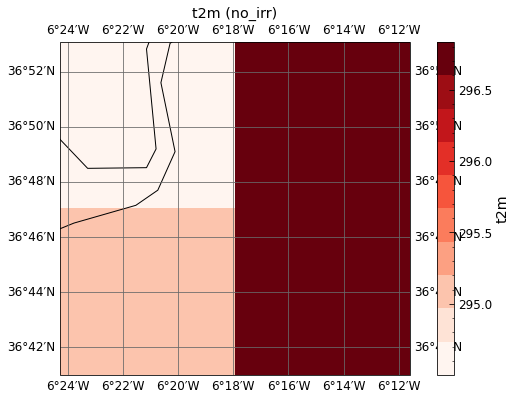

In [84]:
#Display map of var for ds on restricted area
var='t2m'
ds = sim_noirr
# ds = std
latmin=36.7
latmax=36.9
lonmin=-6.4
lonmax=-6.2

#restrict ds to latmin, latmax, lonmin, lonmax
ds = ds.where(ds.lat >= latmin, drop=True)
ds = ds.where(ds.lat <= latmax, drop=True)
ds = ds.where(ds.lon >= lonmin, drop=True)
ds = ds.where(ds.lon <= lonmax, drop=True)
plotvar = ds[var].mean(dim='time')
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#use colormap reds
plotvar.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=reds)
plt.title(var + ' (' + ds.name + ')')

In [85]:
#Display map of var for ds averaged on a given year
var='hydrographs'
year=2012
ds = sim_noirr
# ds = ds.where(ds['time.year'] == year, drop=True)
plotvar = ds[var].mean(dim='time')
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#use colormap reds
plotvar.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=myvir)
plt.title(var + ' (' + ds.name + ')')

KeyError: 'hydrographs'

In [62]:
# create map of wind as vector combining u and v components
ds = sim_irr
dist=6

#compute wind speed
wind_speed = (ds['u850'][0,:,:]**2 + ds['v850'][0,:,:]**2)**(1/2)
#extract x and y (u and v) components and reduce dimension
windx = ds['u850'][0,::dist,::dist]
windy = ds['v850'][0,::dist,::dist]
longi=ds['lon'][::dist]
lati=ds['lat'][::dist]
# wind_speed=(windx**2+windy**2)**(1/2)
# longi,lati=np.meshgrid(longi,lati)

#display map
fig = plt.figure(figsize=(10, 7.5))
ax = plt.axes(projection=ccrs.PlateCarree())
# gridline setup
ax.coastlines()
ax.add_feature(rivers)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.8)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = plt.MaxNLocator(10)
gl.ylocator = plt.MaxNLocator(9)
#use colormap reds
wind_speed.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=reds)
ax.quiver(longi, lati, windx, windy, transform=ccrs.PlateCarree(), scale=100)
plt.title('850hPa wind speed (m/s) and direction in Irr simulation')
plt.show()


KeyError: 'u850'

In [ ]:
# wind difference
ds1 = sim_irr
ds2 = sim_noirr
dist=6

#compute wind speed
wind_speed1 = (ds1['u850'][0,:,:]**2 + ds1['v850'][0,:,:]**2)**(1/2)
wind_speed2 = (ds2['u850'][0,:,:]**2 + ds2['v850'][0,:,:]**2)**(1/2)
wind_speed_diff = wind_speed1 - wind_speed2
#extract x and y (u and v) components and reduce dimension
longi=ds['lon'][::dist]
lati=ds['lat'][::dist]
windx1 = ds1['u850'][0,::dist,::dist]
windy1 = ds1['v850'][0,::dist,::dist]
windx2 = ds2['u850'][0,::dist,::dist]
windy2 = ds2['v850'][0,::dist,::dist]
windx_diff = windx1 - windx2
windy_diff = windy1 - windy2


#display map
fig = plt.figure(figsize=(10, 7.5))
ax = plt.axes(projection=ccrs.PlateCarree())
# gridline setup
ax.coastlines()
ax.add_feature(rivers)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.8)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = plt.MaxNLocator(10)
gl.ylocator = plt.MaxNLocator(9)
#use colormap reds
wind_speed_diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=emb)
ax.quiver(longi, lati, windx_diff, windy_diff, transform=ccrs.PlateCarree(), scale=10)
plt.title('850hPa wind speed (m/s) and direction difference')
plt.show()


# Time series

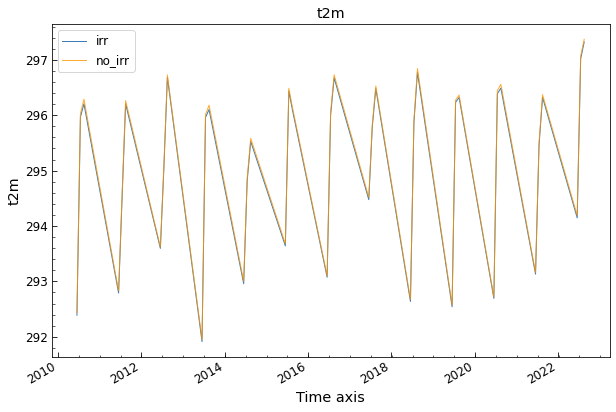

In [50]:
#Average time series
var='t2m'
ds1=sim_irr
ds2=sim_noirr
# ds1 = ds1.where(ds1['time.year'] >= year_min, drop=True).where(ds1['time.year'] <= year_max, drop=True)
# ds2 = ds2.where(ds2['time.year'] >= year_min, drop=True).where(ds2['time.year'] <= year_max, drop=True)
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.grid()
ds1[var].mean(dim=['lon','lat']).plot(ax=ax, label=ds1.name)
ds2[var].mean(dim=['lon','lat']).plot(ax=ax, label=ds2.name)
plt.title(var)
plt.legend()

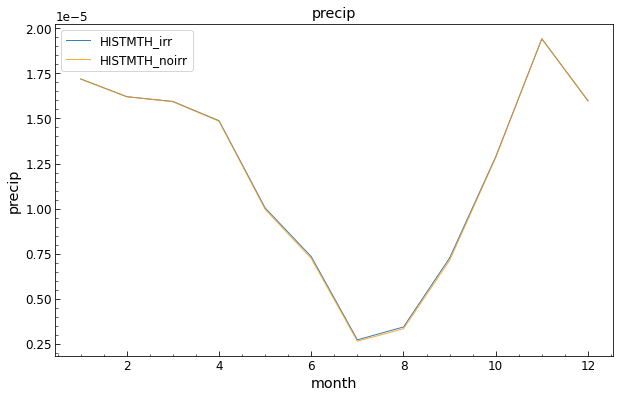

In [58]:
#Average seasonnal cycle
var='precip'
ds1=sim_irr
ds2=sim_noirr
# ds1 = ds1.where(ds1['time.year'] >= year_min, drop=True).where(ds1['time.year'] <= year_max, drop=True)
# ds2 = ds2.where(ds2['time.year'] >= year_min, drop=True).where(ds2['time.year'] <= year_max, drop=True)
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.grid()
ds1[var].mean(dim=['lon','lat']).groupby('time.month').mean(dim='time').plot(ax=ax, label=ds1.name)
ds2[var].mean(dim=['lon','lat']).groupby('time.month').mean(dim='time').plot(ax=ax, label=ds2.name)
plt.title(var)
plt.legend()

# Vertical profiles

In [176]:
filename='/data/ptiengou/JZ_simu_outputs/LAM/HF_outputs_LAM_concat/TS_MO_irr_theta.nc'
theta_irr=xr.open_dataset(filename)
theta_irr.attrs["name"]='irr'
theta_irr

<xarray.Dataset>
Dimensions:            (time_counter: 156, bnds: 2, lon: 200, lat: 200,
                        presnivs: 79)
Coordinates:
  * time_counter       (time_counter) datetime64[ns] 2010-01-16T12:00:00 ... ...
  * lon                (lon) float32 -13.0 -12.89 -12.79 ... 7.789 7.894 8.0
  * lat                (lat) float32 30.0 30.1 30.2 30.3 ... 49.7 49.8 49.9 50.0
  * presnivs           (presnivs) float32 1.012e+05 1.009e+05 ... 5.297 1.483
Dimensions without coordinates: bnds
Data variables:
    time_counter_bnds  (time_counter, bnds) datetime64[ns] ...
    theta              (time_counter, presnivs, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Jun 27 11:21:19 2024: cdo monmean TS_HF_irr_theta.nc TS...
    name:         irr
    description:  Created by xios
    title:        Created by xios
    timeStamp:    2024-Apr-08 20:57:23 GMT
    uuid:         7300fd87-6930-4a45-a625-779cb9f604f7
    NCO:          netCDF Operators version 4.8.1 (Homepage = http://nco.sf.ne...
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [177]:
filename='/data/ptiengou/JZ_simu_outputs/LAM/HF_outputs_LAM_concat/TS_MO_noirr_theta.nc'
theta_noirr=xr.open_dataset(filename)
theta_noirr.attrs["name"]='no_irr'

Text(0, 0.5, 'Pressure (hPa)')

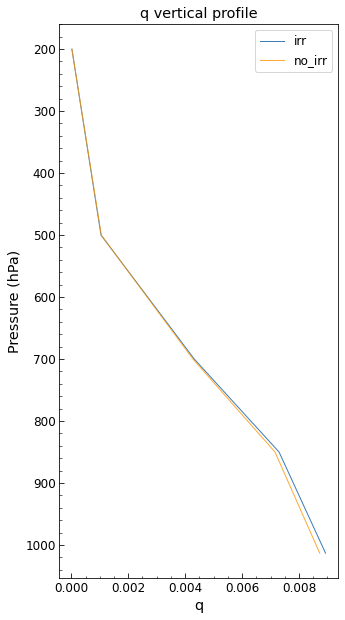

In [208]:
# t and q profiles
#select a lon-lat box
latmin=41
latmax=43
lonmin=-2
lonmax=1
var='q'
ds1=sim_irr.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))
ds2=sim_noirr.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))
#take var at 200 500 700 850 hPa and average over time in ds1
var0=ds1[var+'2m'].mean(dim=['time', 'lon', 'lat'])
var200=ds1[var+'200'].mean(dim=['time', 'lon', 'lat'])
var500=ds1[var+'500'].mean(dim=['time', 'lon', 'lat'])
var700=ds1[var+'700'].mean(dim=['time', 'lon', 'lat'])
var850=ds1[var+'850'].mean(dim=['time', 'lon', 'lat'])
pressure=[200,500,700,850,1013]
profile1=[var200,var500,var700,var850,var0]
#same vor ds2
var0=ds2[var+'2m'].mean(dim=['time', 'lon', 'lat'])
var200=ds2[var+'200'].mean(dim=['time', 'lon', 'lat'])
var500=ds2[var+'500'].mean(dim=['time', 'lon', 'lat'])
var700=ds2[var+'700'].mean(dim=['time', 'lon', 'lat'])
var850=ds2[var+'850'].mean(dim=['time', 'lon', 'lat'])
profile2=[var200,var500,var700,var850,var0]
#plot var as a vertical profile from 850 to 200 hPa
fig = plt.figure(figsize=(5, 10))
ax = plt.axes()
ax.grid()
plt.gca().invert_yaxis()
ax.plot(profile1, pressure, label=ds1.name)  
ax.plot(profile2, pressure, label=ds2.name)  
plt.title(var + ' vertical profile')
plt.legend()
plt.xlabel(var)
plt.ylabel('Pressure (hPa)')

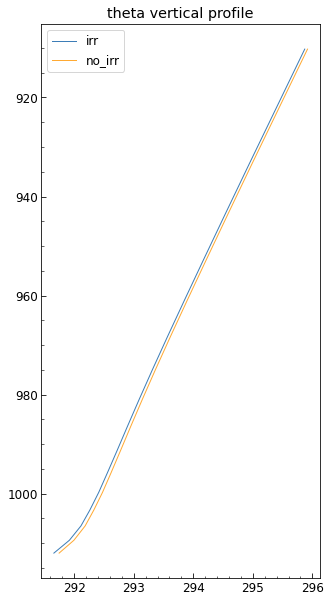

In [191]:
# theta profile
# select a lon-lat box
latmin=41
latmax=43
lonmin=-2
lonmax=1
# #spain
# latmin=36
# latmax=44
# lonmin=-9.5
# lonmax=3
preslevelmax=17
var='theta'
ds1=theta_irr.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))
ds2=theta_noirr.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))

pressure=ds1['presnivs'][0:preslevelmax]/100
profile1=ds1[var].mean(dim=['time_counter', 'lon', 'lat'])[0:preslevelmax]
profile2=ds2[var].mean(dim=['time_counter', 'lon', 'lat'])[0:preslevelmax]

#plot var as a vertical profile from 850 to 200 hPa
fig = plt.figure(figsize=(5, 10))
ax = plt.axes()
ax.grid()
plt.gca().invert_yaxis()
ax.plot(profile1, pressure, label=ds1.name)  
ax.plot(profile2, pressure, label=ds2.name)  
plt.title(var + ' vertical profile')
plt.legend()
# plt.xlabel(var)
# plt.ylabel('Pressure (hPa)')